# **Providing data-driven suggestions for HR**

### Understand the business scenario and problem

This project involves analyzing HR data to provide actionable insights to improve employee retention within an organization. By constructing predictive models, the aim is to identify factors associated with employee turnover. The deliverables include model evaluations, data visualizations, and ethical considerations, culminating in a concise project summary and a comprehensive code notebook.They have the following question: what’s likely to make the employee leave the company?

The dataset that I'll be using in this lab contains 15,000 rows and 10 columns for the variables listed below. 

**Note:** For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)


## Step 1. Imports

*   Import packages
*   Load dataset

### Import packages

In [105]:
# Import packages

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# For data manipulation
import numpy as np
import pandas as pd
import scipy.stats as stats
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle


### Load dataset

In [4]:
# Load dataset into a dataframe

df0 = pd.read_csv("HR_comma_sep.csv")

# Display first few rows of the dataframe

df0.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


## Data Exploration (Initial EDA and data cleaning)


### Gather basic information about the data

In [7]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [9]:
# Gather descriptive statistics about the data

df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Rename columns

In [11]:
# Display all column names

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [12]:
# Rename columns as needed

df0 = df0.rename(columns={'Work_accident': 'work_accident',
                         'average_montly_hours': 'average_monthly_hours',
                         'time_spend_company': 'tenure',
                         'Department': 'department'})

# Display all column names after the update

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

Check for any missing values in the data.

In [14]:
# Check for missing values

df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

### Check duplicates

Check for any duplicate entries in the data.

In [16]:
# Check for duplicates

df0.duplicated().sum()

3008

In [17]:
# Inspect some rows containing duplicates as needed

df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [18]:
# Drop duplicates and save resulting dataframe in a new variable as needed

df1 = df0.drop_duplicates(keep='first')

# Display first few rows of new dataframe as needed

df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check for outliers

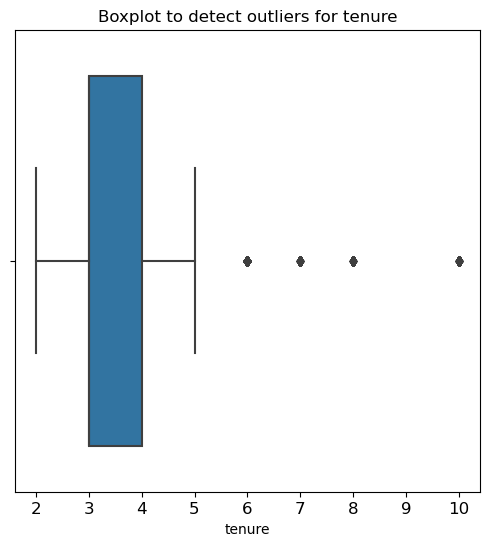

In [20]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers

plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

In [21]:
# Determine the number of rows containing outliers

percentile25=df1['tenure'].quantile(.25)

percentile75=df1['tenure'].quantile(.75)

iqr = percentile75 - percentile25

upper_limit = percentile25 - 1.5 * iqr
lower_limit = percentile75 + 1.5 * iqr

print('Lower Limit:', lower_limit)
print('Upper Limit:', upper_limit)

outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

print('Number of rows in the data containing outliers in "tenure":', len(outliers))

Lower Limit: 5.5
Upper Limit: 1.5
Number of rows in the data containing outliers in "tenure": 11991


# Continue EDA (analyze relationships between variables)



In [23]:
# Get numbers of people who left vs. stayed

print(df1['left'].value_counts())
# Get percentages of people who left vs. stayed

print(df1['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64
left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


## Data visualizations 


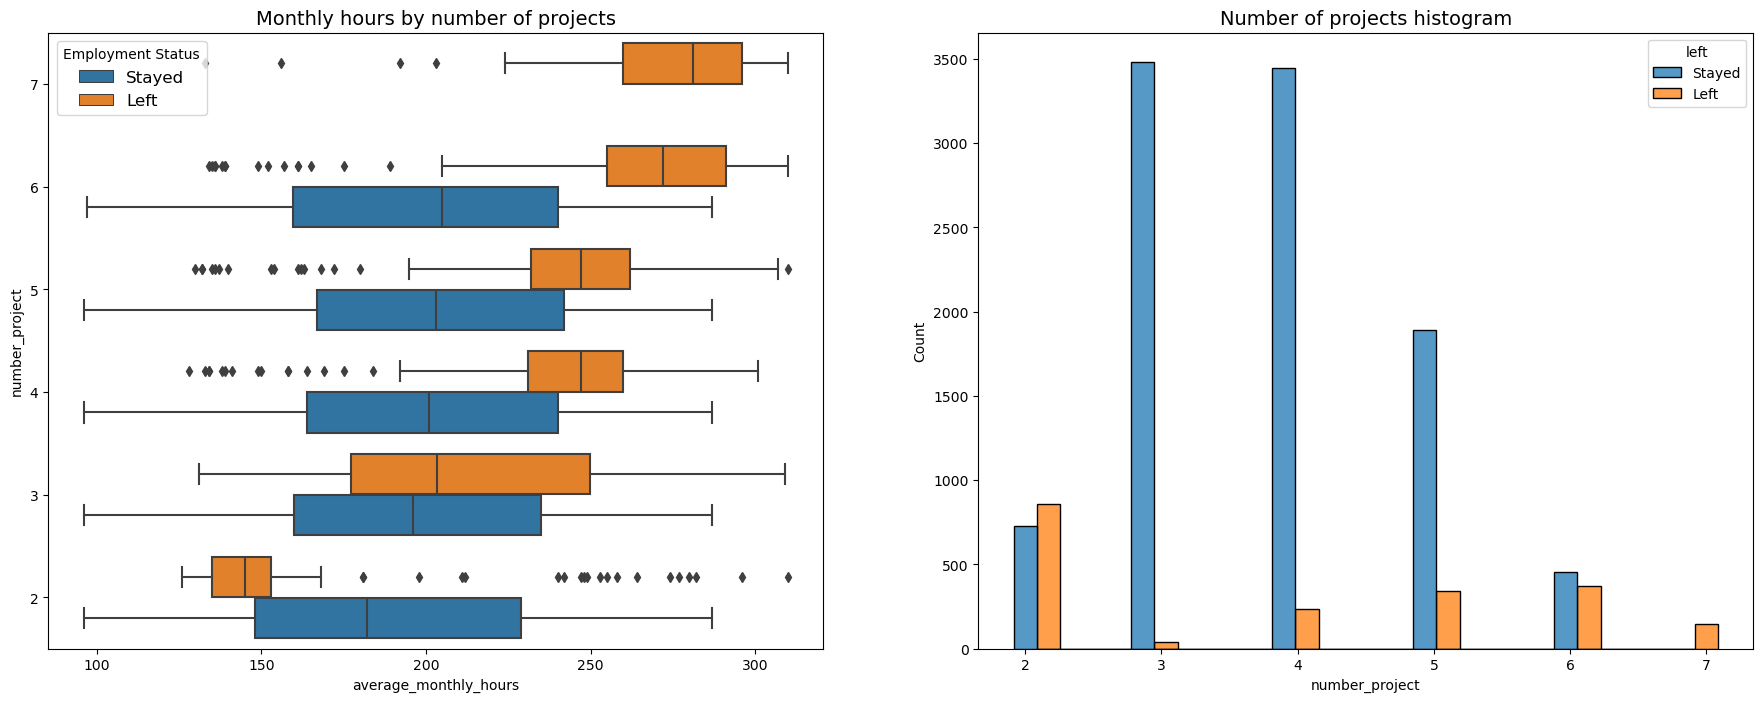

In [273]:
# Monthly hours X Number of projects boxplot AND Number of Projects histogram


# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')
# Get the current handles and labels
handles, labels = ax[0].get_legend_handles_labels()

# Define new labels
new_labels = ['Stayed', 'Left']

# Update the legend
ax[0].legend(handles, new_labels, title="Employment Status")

# Optionally, you can set the fontsize of the legend
ax[0].legend(handles, new_labels, title="Employment Status", fontsize='12')

# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

# Set the legend labels
legend_labels = ['Stayed', 'Left']
for t, l in zip(ax[1].get_legend().texts, legend_labels):
    t.set_text(l)

# Set the title for the subplot
ax[1].set_title('Number of projects histogram', fontsize='14')
# Display the plots
plt.show()

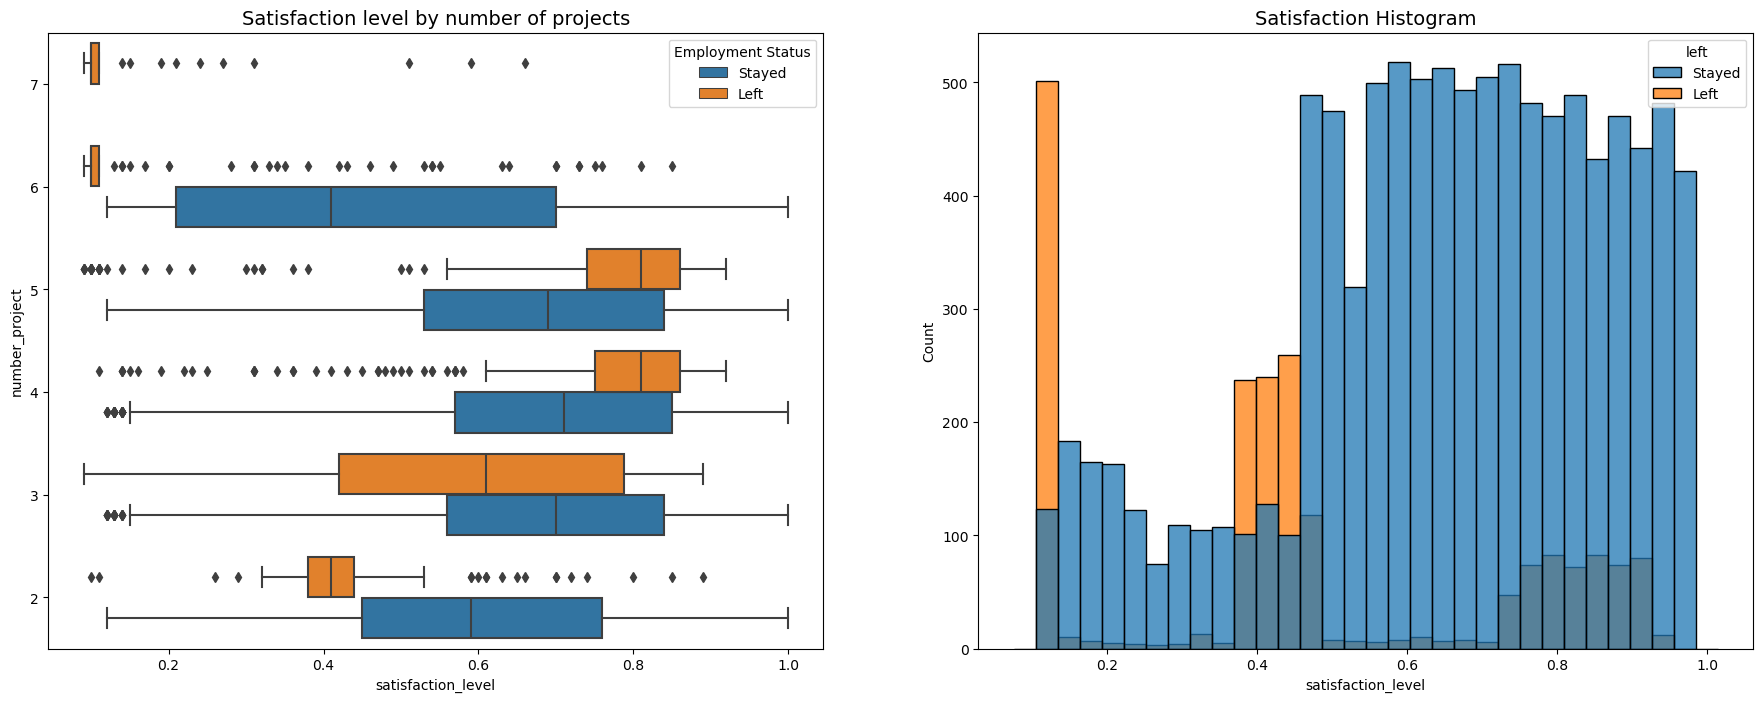

In [277]:
# Satisfaction X Project boxplot AND Satisfaction Histogram

# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing `satisfaction_level` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction level by number of projects', fontsize='14')
# Get the current handles and labels
handles, labels = ax[0].get_legend_handles_labels()

# Define new labels
new_labels = ['Stayed', 'Left']

# Update the legend
ax[0].legend(handles, new_labels, title="Employment Status")

# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
sns.histplot(data=df1, x='satisfaction_level', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Satisfaction Histogram', fontsize='14')

# Set the legend labels
legend_labels = ['Stayed', 'Left']
for t, l in zip(ax[1].get_legend().texts, legend_labels):
    t.set_text(l)

# Display the plots
plt.show();


In [269]:
# Investigating projects vs employee staying/leaving

print(df1[df1['number_project']==6]['left'].value_counts())
print(df1[df1['number_project']==7]['left'].value_counts())


left
0    455
1    371
Name: count, dtype: int64
left
1    145
Name: count, dtype: int64


### All employees with 7 projects left the company, while almost 50% of the employees with 6 left as well.

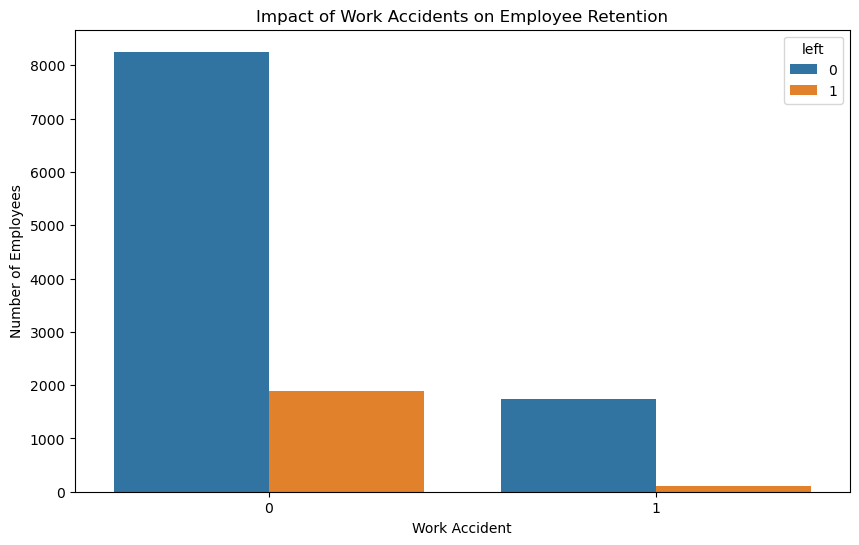

In [271]:
# Creating a visual to show if 'work_accident' has an impact on retention

# Group the data by 'work_accident' and 'left', and calculate the count
counts = df1.groupby(['work_accident', 'left']).size().reset_index(name='count')

# Convert categorical columns to strings for plotting
counts['work_accident'] = counts['work_accident'].astype(str)
counts['left'] = counts['left'].astype(str)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=counts, x='work_accident', y='count', hue='left')

# Adding labels and title
plt.title('Impact of Work Accidents on Employee Retention')
plt.xlabel('Work Accident')
plt.ylabel('Number of Employees')


# Show plot
plt.show()

### Work Accidents don't really seem to have much of an impact on employee retention, potentially even making people more likely to stay?

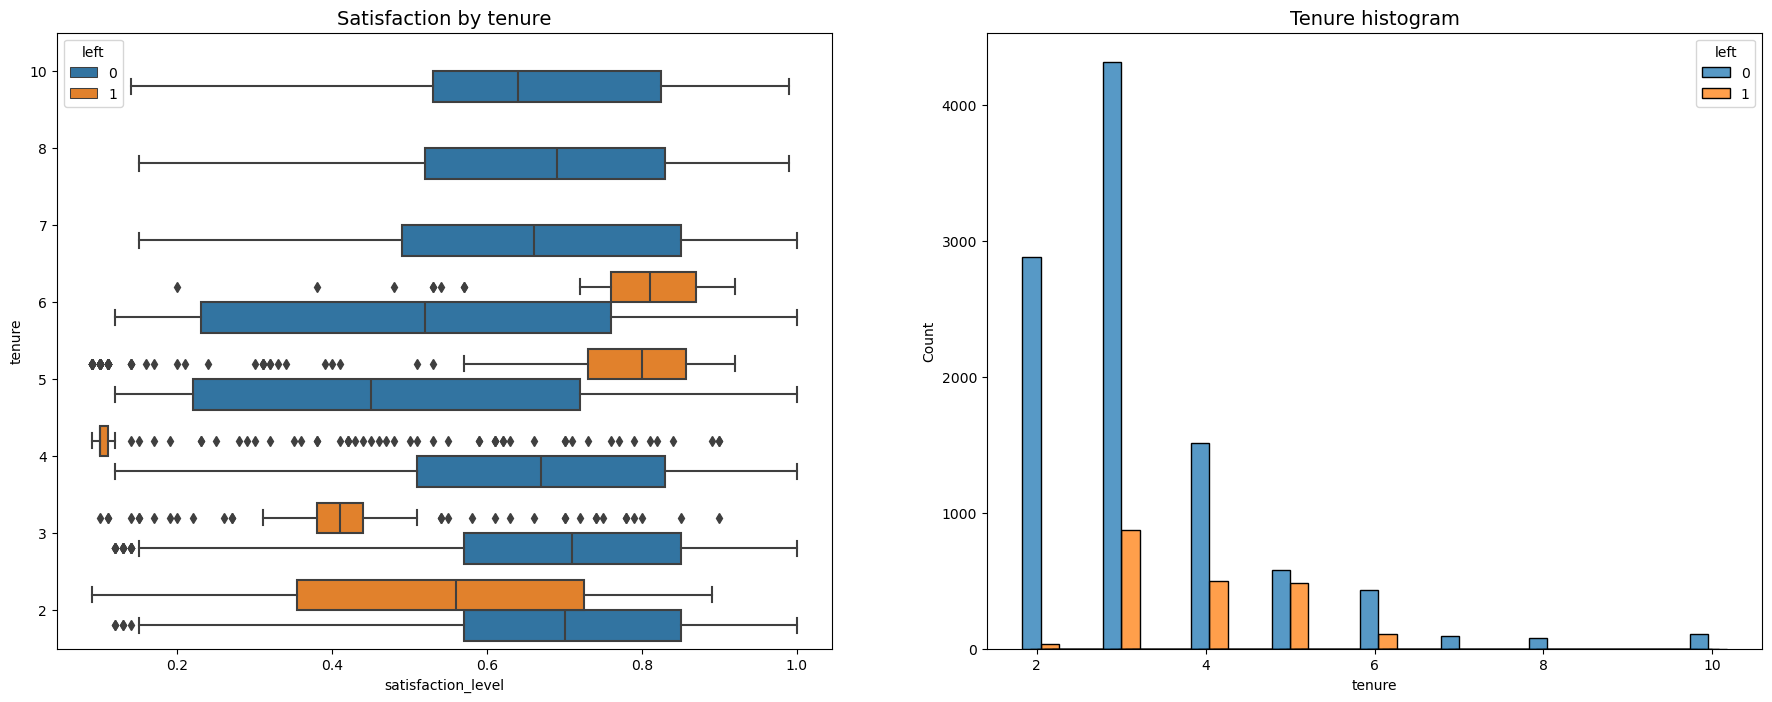

In [281]:
# Satisfaction X Tenure boxplot AND Tenure Histogram

# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

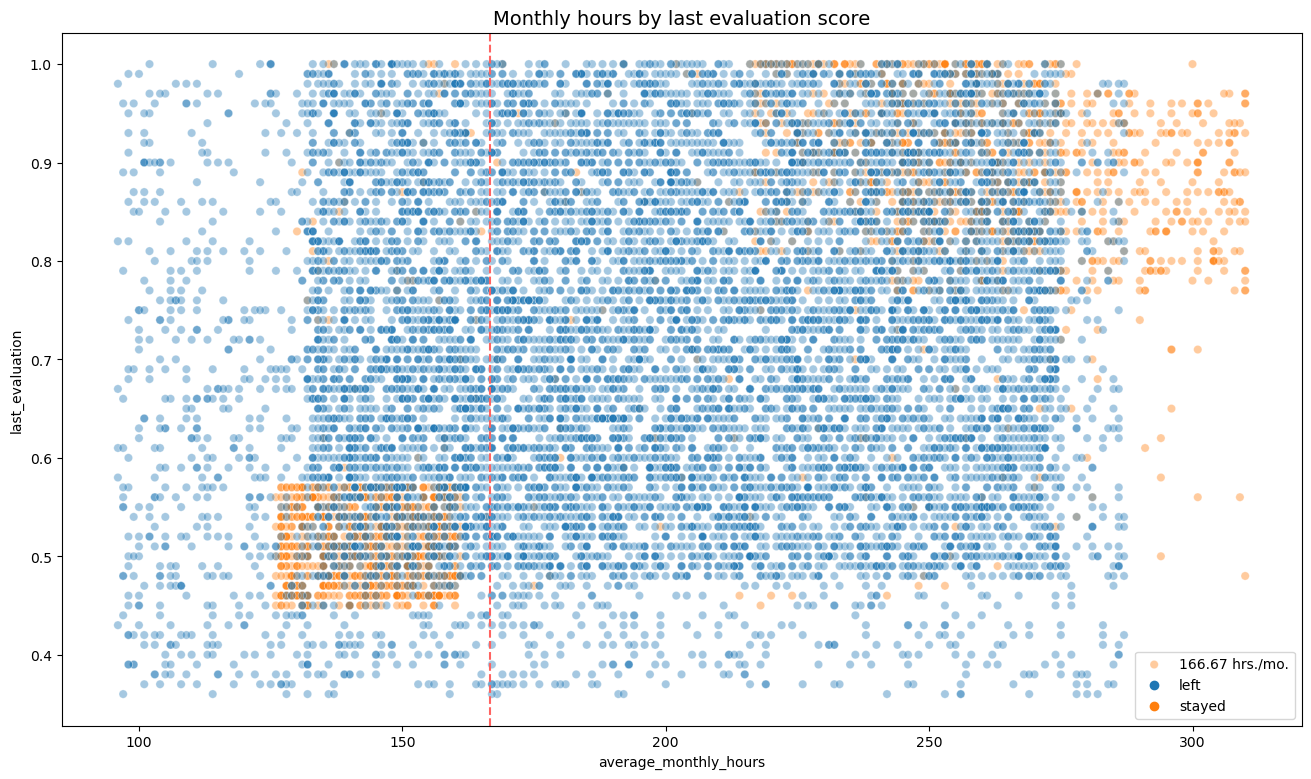

In [285]:
# Scatterplot showing relationship between average monthly hours and last evaluation score

# Create scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

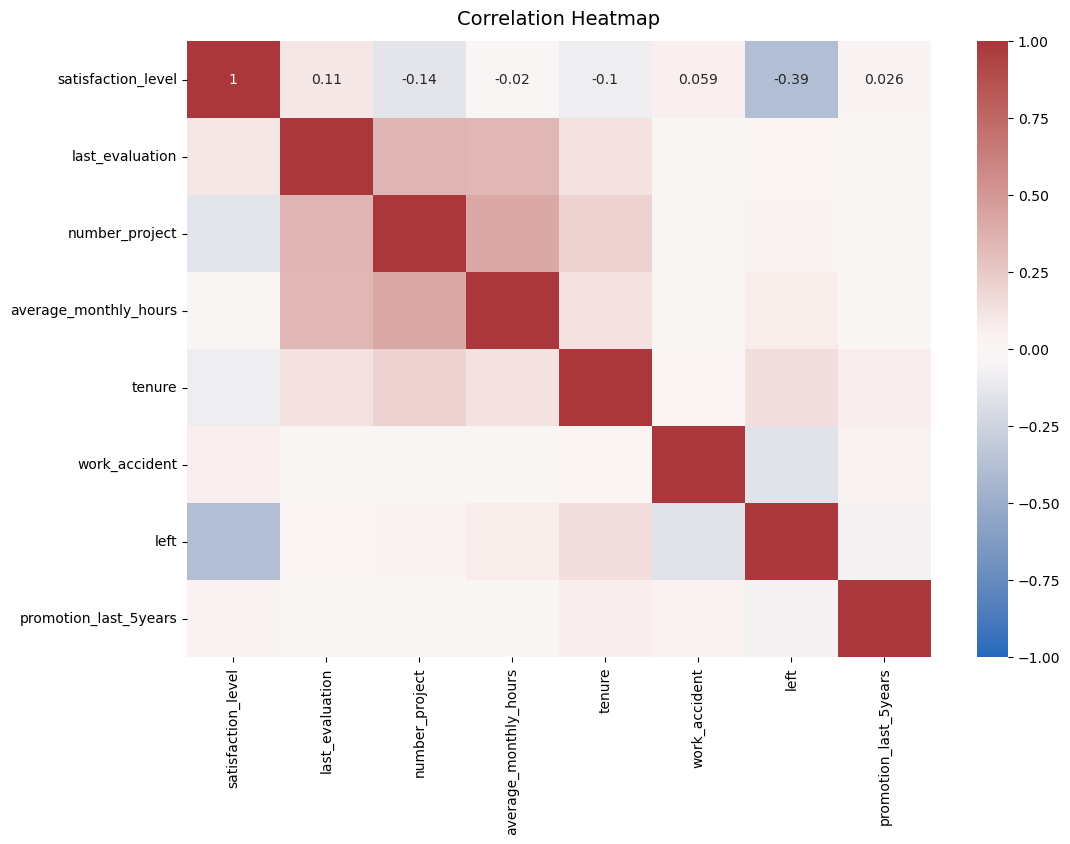

In [287]:
# Filter the DataFrame to include only numeric columns
numeric_df = df0.select_dtypes(include=['float64', 'int64'])

# Ensure there are no missing values that could disrupt the correlation matrix
numeric_df = numeric_df.dropna()

# Clear any previous plots
plt.clf()
plt.close('all')

# Plot a correlation heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
heatmap = sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)

# Show plot
plt.show()

### Insights

A lot of the employees that left the company were on the high end of being overworked, while another good portion of them were slightly underworked but received lower than expected evaluation scores. 

No employee that has been at the company more than 6 years has left.

Work accidents don't seem to have any real impact on whether an employee stays or leaves.

Employees satisfaction levels drop significantly once they have more than 6 projects to work on.


## Model Building, 

### Identify the type of prediction task.

The prediction requested is a binomial outcome, left or stayed. The outcome will be categorical.

### Identify the types of models most appropriate for this task.

Since it is a categorical outcome, a Log Regression model or Tree-based model will be the best approach.

## Modeling Approach: Tree-based Model

In [34]:

df = df1.copy()

df['salary'] = (
    df['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

df = pd.get_dummies(df, drop_first=False)

df.head(5)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [35]:
#isolate outcome variable
y = df['left']

y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [36]:
# Select the features

X = df.drop('left', axis=1)

X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [97]:
# Split the data into train / test / split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 0)

In [107]:
# Instantiate the model
tree = DecisionTreeClassifier(random_state=0)

# Create hyperparamaters
cv_params = {'max_depth': [4, 6, 8, None],
            'min_samples_leaf': [2, 5, 1],
            'min_samples_split': [2, 4, 6]
            }

# Assign dictionary of scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [109]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 1.98 s
Wall time: 1.98 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [111]:
# Check best parameters

tree1.best_params_

{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [113]:
# Check best AUC on CV

tree1.best_score_

0.9548070613085594

In [115]:
def make_results(model_name:str, model_object, metric:str):
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [296]:
# Get cv scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.971662,0.914947,0.94238,0.98143,0.954807


In [123]:
# Instantiate the model
rf = RandomForestClassifier(random_state=0)

# Create hyperparamaters
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500]
            }

# Assign dictionary of scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [125]:
%%time
rf1.fit(X_train, y_train)

CPU times: total: 13min 1s
Wall time: 13min 2s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [143]:
# Save and pickle the model

path = 'models'

In [145]:
def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)
    
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    return model

In [147]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')
# Read pickle
read_pickle(path, 'hr_rf1')

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [149]:
# Check best AUC score
rf1.best_score_

0.9560746240197273

In [151]:
# Check best params
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [153]:
# Get all cv scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall       F1  accuracy       auc
0  decision tree cv   0.971662  0.914947  0.94238   0.98143  0.954807
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.984833  0.914949  0.948572  0.983543  0.956075


In [155]:
def get_scores(model_name:str, model, X_test_data, y_test_data):

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [157]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.991361,0.921687,0.955255,0.985657,0.960043


In [159]:
# Feature engineering

## Drop satisfaction level, could possibly be causing data leakage as employees already intent
## on leaving could be working differnt hours

df_edit = df.drop('satisfaction_level', axis=1)

df_edit.head(5)

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [161]:
# Rework overworked feature

df_edit['overworked'] = df_edit['average_monthly_hours']

print('Max hours:', df_edit['overworked'].max())
print('Min hours:', df_edit['overworked'].min())

Max hours: 310
Min hours: 96


In [163]:
df_edit['overworked'] = (df_edit['overworked'] > 175).astype(int)

df_edit['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int32

In [165]:
df_edit = df_edit.drop('average_monthly_hours', axis=1)
df_edit.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


## Re split, train, test with random forest and decision tree on the modified data frame with the changed 'overworked' variable

In [167]:
y = df_edit['left']

X = df_edit.drop('left', axis=1)

In [169]:
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=0)


In [182]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

cv_params = {'max_depth':[4,6,8,None],
             'min_samples_leaf': [2,5,1],
             'min_samples_split': [2,4,6]
            }

# Assign scoring dictionary
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [184]:
%%time
tree2.fit(X_train, y_train)

CPU times: total: 1.67 s
Wall time: 1.68 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [186]:
# Check best params and AUC score
print(tree2.best_params_)
print(tree2.best_score_)

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}
0.9365100103702217


In [188]:
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall       F1  accuracy       auc
0  decision tree cv   0.971662  0.914947  0.94238   0.98143  0.954807
               model  precision    recall        F1  accuracy      auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.93651


In [192]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc') 

In [194]:
%%time
rf2.fit(X_train, y_train)

CPU times: total: 9min 14s
Wall time: 9min 15s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [199]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [201]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [203]:
# Check best params
rf2.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [205]:
# Check best AUC score on CV
rf2.best_score_

0.9350040324392004

In [294]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)


               model  precision    recall        F1  accuracy      auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.93651
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.910057  0.887475  0.898603  0.966752  0.935004


In [209]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.900407,0.889558,0.894949,0.96531,0.934979


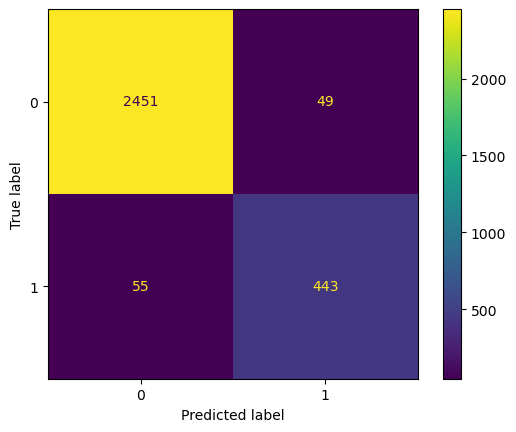

In [211]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

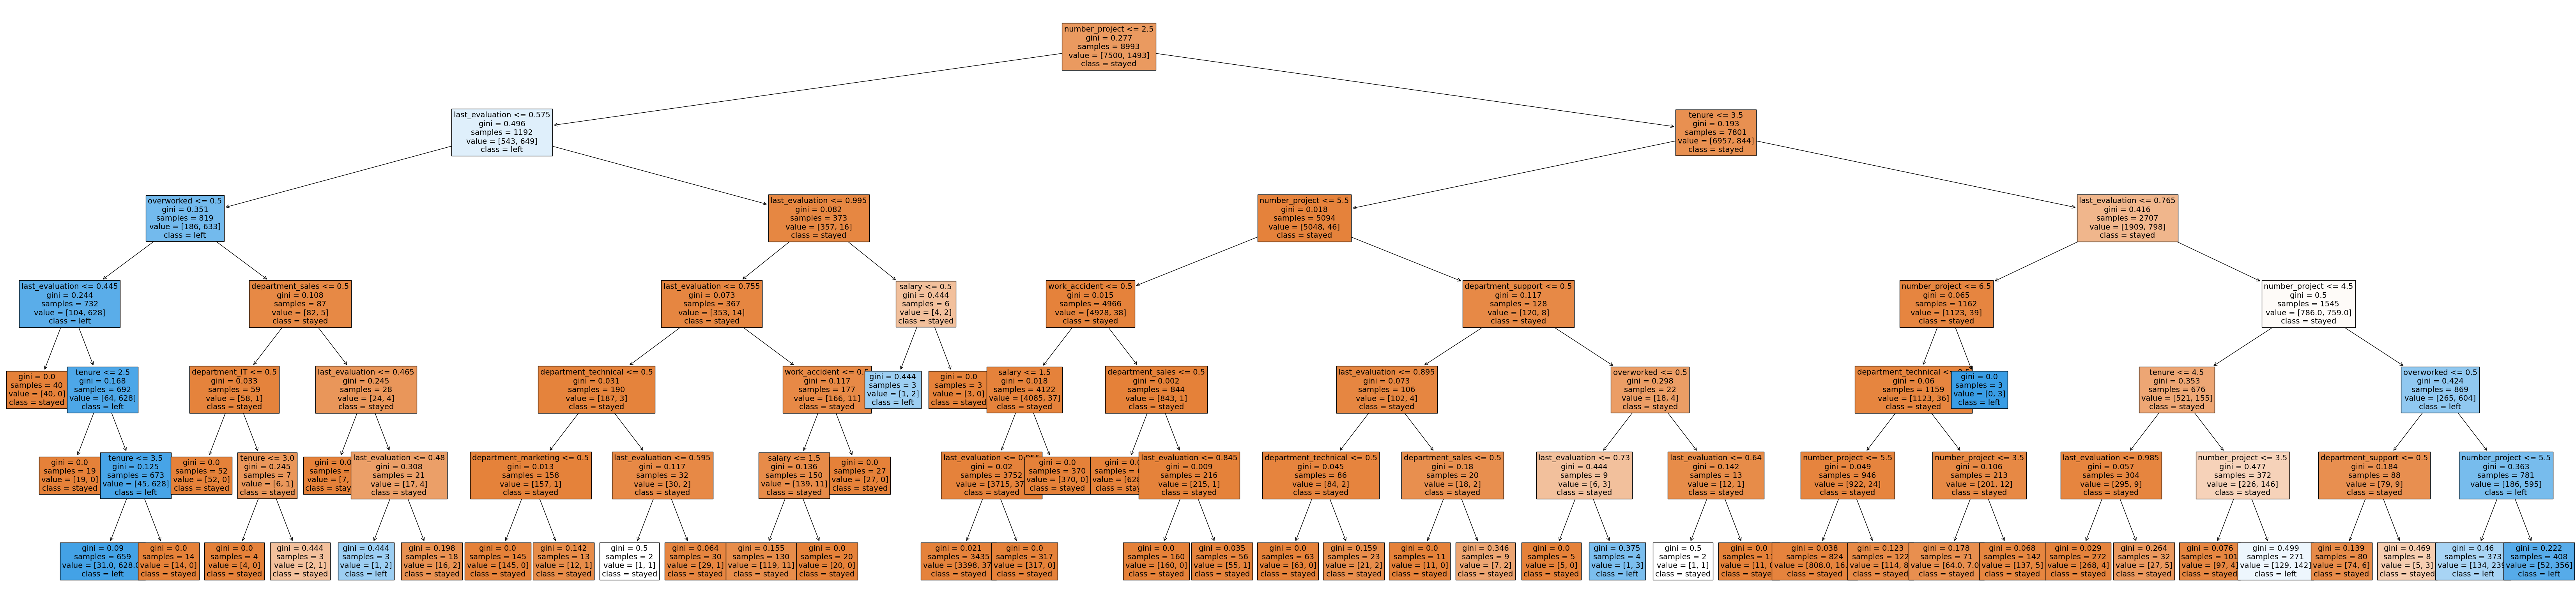

In [213]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [215]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
last_evaluation,0.343958
number_project,0.343385
tenure,0.215681
overworked,0.093498
department_support,0.001142
salary,0.000910
department_sales,0.000607
department_technical,0.000418
work_accident,0.000183
department_IT,0.000139


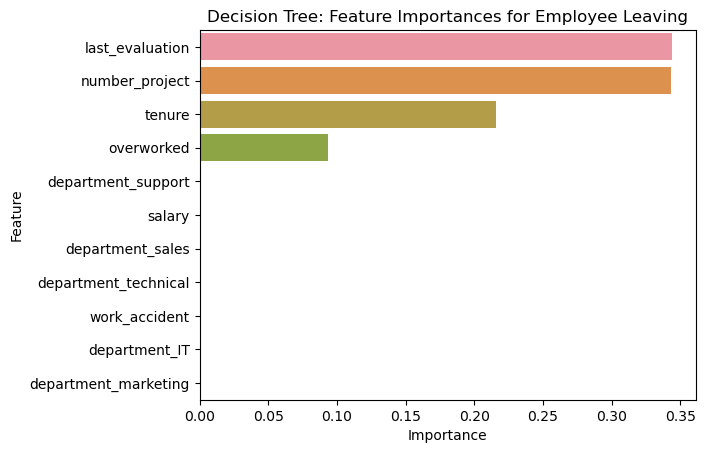

In [217]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

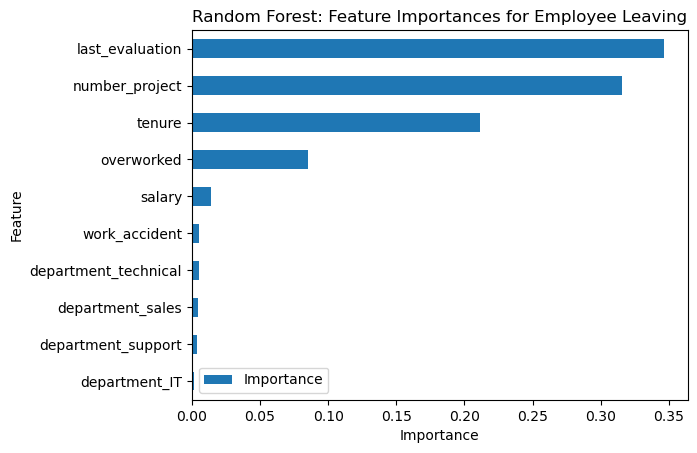

In [219]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

## Results and Evaluation




**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 93.7%, precision of 85.7%, recall of 90.4%, f1-score of 87.9%, and accuracy of 95.9%, on the test set. \
The random forest modestly outperformed the decision tree model. 

### Conclusion, Recommendations, Next Steps

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following recommendations could be presented to the stakeholders:

* Cap the number of projects that employees can work on. (5 or 6 projects at maximum, I'd suggest 5 and see the effects of that initially)
* Conduct further investigation about why four-year tenured employees are so dissatisfied, potentially a low amount of 4-year employees? If that's the case, why?
* Figure out a way to have employees work less, or reward them adequately for working more.
* Possibly restructure environment, make sure employees don't feel the need to be overworked, potentially an understaffed issue or workflow efficiency problem?
* High evaluation scores shouldn't be so correlated with being overworked. Consider implementing team rewards so individuals don't feel the need to work so much more than is needed.
